**Chapter 3 – Classification**

_This notebook contains all the sample code and solutions to the exercises in chapter 3._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/notyetend/handson-ml2/blob/master/03_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

In [5]:
28 * 28

784

Saving figure some_digit_plot


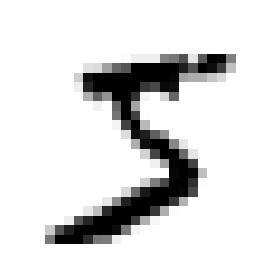

In [6]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [7]:
y[0]

'5'

In [8]:
y = y.astype(np.uint8)

In [9]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [10]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


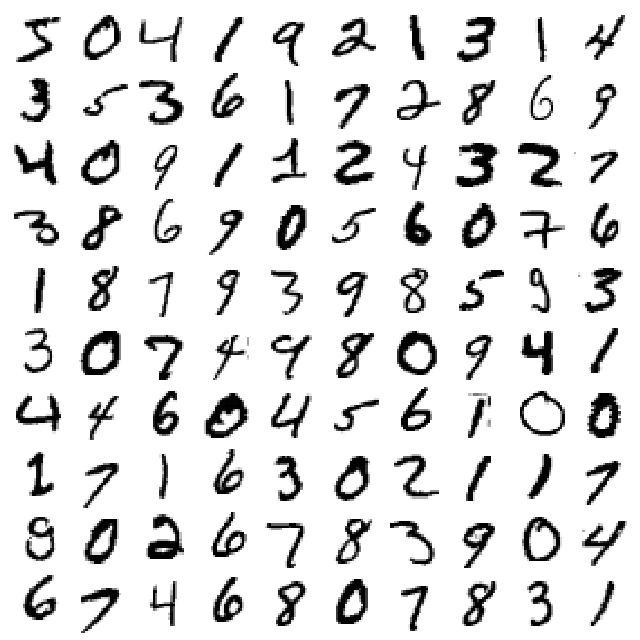

In [11]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [12]:
y[0]

5

###### 왜 6만개만 사용하지?

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

###### 우선 2항 분류만 하기 위해서 숫자 그림이 5인지 아닌지로 나눈다.

# Binary classifier

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [15]:
y_train_5

array([ True, False, False, ...,  True, False, False])

**Note**: some hyperparameters will have a different defaut value in future versions of Scikit-Learn, such as `max_iter` and `tol`. To be future-proof, we explicitly set these hyperparameters to their future default values. For simplicity, this is not shown in the book.

###### SGD는 바로 그 Stochastic Gradient Descent인가? 이게 왜 여기서 나와?     그게 아니라 regularized linear models with stochastic gradient descent (SGD)

In [16]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

###### 2항 분류 문제로 바꿨기 때문에 예측 결과도 True/False이다.

In [17]:
sgd_clf.predict([some_digit])

array([ True])

###### 3-fold cv를 했을 때, 각 fold의 accuracy를 보여준다.

In [18]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

###### StratifiedKFold는 층화 K-fold? 인가? 어떤 feature를 기준으로 층을 나눌지 지정하는게 나오겠지? 그런데 바로 앞에서 cross_val_score를 사용하는 것과 뭐가 다르지? 같은걸 다른 방법으로 해본건가? 결과는 조금 다르네..

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [20]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

###### 헐~ 항상 False로만 예측하는 classifier에 대한 accuracy는 높다. 이건 False 샘플이 90%에 육박하기 때문이다.

In [21]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

###### cross_val_predict는 뭐하는 것인가?

> The function cross_val_predict has a similar interface to cross_val_score, but returns, for each element in the input, the prediction that was obtained for that element when it was in the test set. Only cross-validation strategies that assign all elements to a test set exactly once can be used (otherwise, an exception is raised).

> cv 셋을 나눌때 각 샘플은 딱 한번식만 test 셋에 들어가도록 나뉜다. 예를들어 1번부터 100번 샘플까지 있고 cv=4로 나눴다면, 1\~25, 25\~50, 51\~75, 76\~100 이렇게 4가지 test 셋이 존재할 수 있으며, 각 셈플이 테스트 셋에 속했을 때 예측값을 cross_val_predict가 반환한다.

In [22]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [23]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [24]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)  # 라벨, 예측값
# i-th row and j-th column entry indicates the number of samples with true label being i-th class and prediced label being j-th class.
# TP FN
# FP TN

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [25]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [26]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

###### 이 숫자는 뭐지?

In [27]:
4096 / (4096 + 1522)

0.7290850836596654

In [28]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [29]:
4096 / (4096 + 1325)

0.7555801512636044

In [30]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [31]:
4096 / (4096 + (1522 + 1325) / 2)

0.7420962043663375

###### 문서에는 decision_function에 대한 설명으로 'Predict confidence scores for samples.'라고 적혀 있다. confidence score는 뭘까?

> The confidence score for a sample is the signed distance of that sample to the hyperplane.

> 즉 공간을 나누는 하이퍼 플레인과 샘플간의 +-거리이다.

In [32]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [33]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [34]:
y_some_digit_pred

array([ True])

In [35]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

###### cross_val_predict을 이용해 각 샘플에 대한 어떤 값을 얻을지 method="decision_function"와 같은 방식으로 지정할 수 있구나
> 그런데 그냥 모델 학습시키고 predict하면 될거 같은데, cross_val_predict를 사용하는 이점이 있나???????

In [36]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

### precisions, recalls, thresholds

In [37]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [38]:
len(precisions), len(recalls), len(thresholds), len(y_train_5), len(y_scores)

# 이상하다. y_train_5와 y_scores는 6천개인데, 왜 precisions, recalls, thresholds는 그렇지 않을까?

(59967, 59967, 59966, 60000, 60000)

In [39]:
# F1-score를 추가해보자.
f1 = 2 * (precisions * recalls) / (precisions + recalls)
len(f1), max(f1), min(f1)

(59967, 0.7590702947845804, 0.0)

In [40]:
precisions >= 0.90

array([False, False, False, ...,  True,  True,  True])

In [41]:
np.argmax(precisions >= 0.90)

57075

In [42]:
np.argmin(precisions >= 0.90)

0

Saving figure precision_recall_vs_threshold_plot


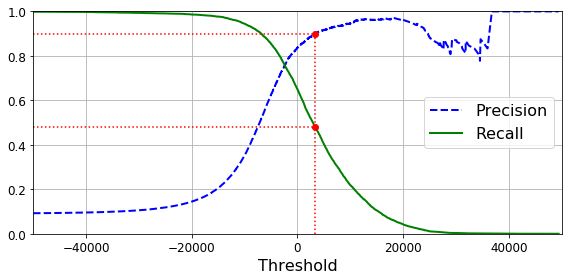

In [43]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

In [44]:
# y_scores는 결정면(decision plane)과의 +- 거리이다.
(y_train_pred == (y_scores > 0)).all()

True

###### F1-score도 그려보면 아래와 같다.

In [45]:
def get_f_beta_score(precisions, recalls, beta=1):
    return (1 + beta**2) * (precisions * recalls) / (beta**2 * precisions + recalls)

Saving figure precision_recall_vs_threshold_plot


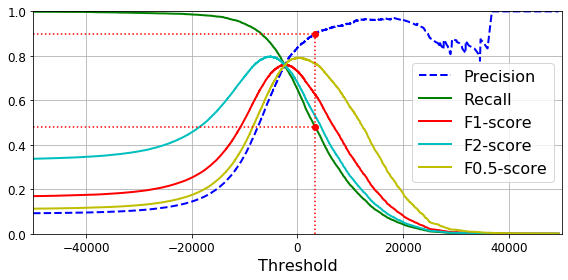

In [46]:
def plot_precision_recall_f1_vs_threshold(precisions, recalls, thresholds):
    f1 = get_f_beta_score(precisions, recalls, 1)
    f2 = get_f_beta_score(precisions, recalls, 2)
    f_half = get_f_beta_score(precisions, recalls, 0.5)
    
    
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.plot(thresholds, f1[:-1], "r-", label="F1-score", linewidth=2)
    plt.plot(thresholds, f2[:-1], "c-", label="F2-score", linewidth=2)
    plt.plot(thresholds, f_half[:-1], "y-", label="F0.5-score", linewidth=2)
    
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_f1_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

###### precision은 왜 threshold 2만 이상에서 찌그러지는걸까?
> 책 95 페이지(원서)에 있는 설명에 따르면, threshold를 높이다보면 precision의 분포에 해당하는 TP + FP가 줄어든다. 예를들어 TP/(TP+FP)가 4/5에서 3/4로 변하는 경우 precision 감소

###### threshold에 따른 FN, TP, FN, TN 건수도 그려본다.

In [47]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [48]:
def fast_confusion_matrix_with_threshold(y_true, y_scores, threshold):
    # fn: 1, 0
    # tp: 1, 1
    # fp: 0, 1
    # tn: 0, 0
    y_pred = y_scores >= threshold
    inv_y_true = np.invert(y_true)
    inv_y_pred = np.invert(y_pred)
    fn = sum(y_true * inv_y_pred)
    tp = sum(y_true * y_pred)
    fp = sum(inv_y_true * y_pred)
    tn = sum(inv_y_true * inv_y_pred)
    # TN FP
    # FN TP
    return {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}

In [49]:
confusion_matrix(y_train_5, y_scores > 0)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [50]:
fast_confusion_matrix_with_threshold(y_train_5, y_scores, 0)

{'tn': 53892, 'fp': 687, 'fn': 1891, 'tp': 3530}

confs = [0] * len(thresholds)
for i, t in enumerate(thresholds):
    confs[i] = fast_confusion_matrix_with_threshold(y_train_5, y_scores, t)
    if i % 100 == 0:
        print(i)

import pandas as pd

df_confs = pd.DataFrame(confs)
df_confs.columns

df_confs.describe()

def plot_confusions(tns, fps, fns, tps, thresholds):
    plt.plot(thresholds, tns, "b--", label="TN", linewidth=2)
    plt.plot(thresholds, fps, "g-", label="FP", linewidth=2)
    plt.plot(thresholds, fns, "r-", label="FN", linewidth=2)
    plt.plot(thresholds, tps, "c-", label="TP", linewidth=2)
    
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 54579])             # Not shown



plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_confusions(df_confs.tn, df_confs.fp, df_confs.fn, df_confs.tp, thresholds)
plt.show()

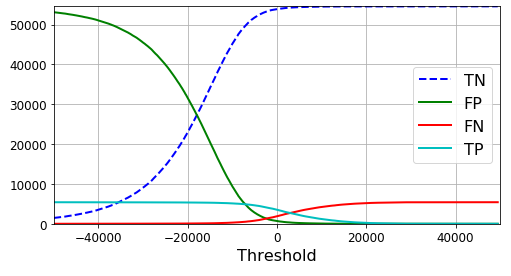

아래 두가지를 관찰할 수 있는데 각각 무슨 의미일까?
- 위 그림을 보면 TN과 FP가 FN과 TP에 비해 매우 큼. $\rightarrow$ 0라벨 샘플이 1라벨 샘플에 비해 매우 많다는 것.
- TN과 FP가 교차하는 지점과 FN과 TP가 교차하는 지점이 꽤 떨어져 있음.  $\rightarrow$ TN이 높고 FP가 낮을 수록 좋은 threshold값이라고 할 수 있음. 그리고 TN이 충분히 높고, FP가 충분히 낮음에도 여전히 TP가 높고, FN이 낮다면 더더욱 좋을 것임. 그런데 threshold가 커질수록 TP는 줄어들고 FN은 늘어나므로 두 교차점 사이의 거리가 멀거나, TN이 높고 FP는 낮으면서도 TP가 높고 FN이 낮은 구간이 길다면 넓은 threshold 구간에서 좋은 성능을 내는 모델이라 할 수 있음.

###### Precision vs Recall plot

Saving figure precision_vs_recall_plot


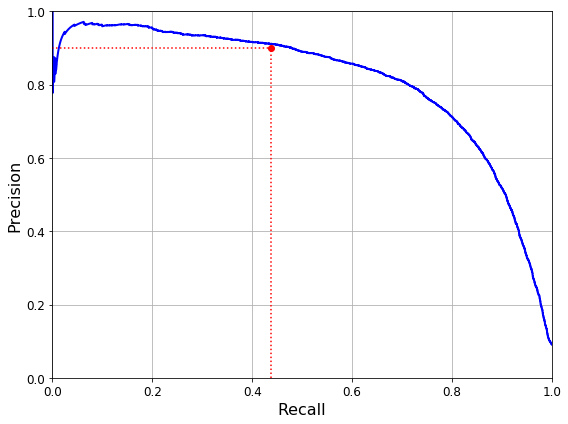

In [51]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [52]:
precisions >= 0.90

array([False, False, False, ...,  True,  True,  True])

In [53]:
# np.argmax는 인자로 주어진 시퀀스에서 값이 가장 클때의 index 값을 반환
# np.argmax(precisions >= 0.90) 이건 precision이 0.9보다 큰 가장 우측 index
# 위 그림에서 빨간 점에 해당하는 threshold를 찾는 것이다.
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [54]:
threshold_90_precision

3370.0194991439557

In [55]:
# 위에서 구한 threshold를 기준으로한 예측값을 찾는다.
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [56]:
# 다시 precision을 계산한다.(다시 확인 하는 것..)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [57]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

# ROC curves

In [58]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


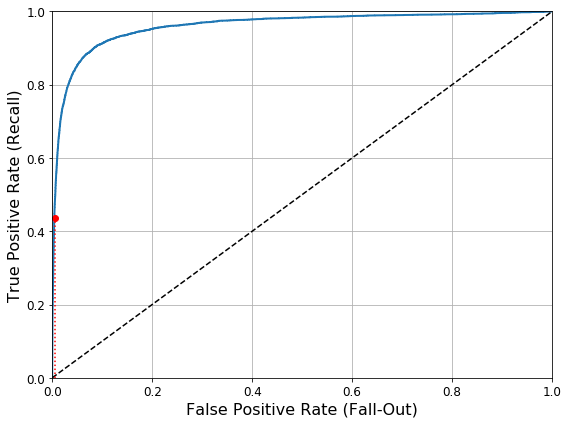

In [59]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
save_fig("roc_curve_plot")                         # Not shown
plt.show()

In [60]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

###### 이번에는 cross_val_predict의 method인자로 "predict_proba"를 사용하고 있다. 이건 뭘까?
> 각 라벨에 대한 확률 값을 반환하게 된다. 반환값의 컬럼은 각 라벨에 대응되는데, 그 순서는 정렬?순서라고 한다. 어떤 정렬순서라는건가 도대체

**Note**: we set `n_estimators=100` to be future-proof since this will be the default value in Scikit-Learn 0.22.

In [61]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [62]:
y_train_5

array([ True, False, False, ...,  True, False, False])

In [63]:
y_probas_forest  # 여기서는 각 컬럼이 False, True에 대응하나보다.

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [64]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Saving figure roc_curve_comparison_plot


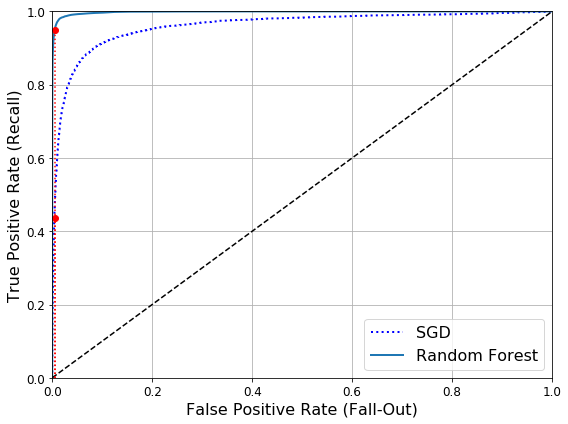

In [65]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [66]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [67]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [68]:
y_train_pred_forest

array([ True, False, False, ...,  True, False, False])

In [69]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

###### CatBoost는 어떤지 한번 해 보자.

In [70]:
from catboost import CatBoostClassifier

In [71]:
cb_model = CatBoostClassifier()
# iterations=2, learning_rate=1, depth=30

In [72]:
y_probas_cb = cross_val_predict(cb_model, X_train, y_train_5, cv=3, 
                                    method="predict_proba")

Learning rate set to 0.049775
0:	learn: 0.6165393	total: 119ms	remaining: 1m 58s
1:	learn: 0.5464562	total: 173ms	remaining: 1m 26s
2:	learn: 0.4878538	total: 226ms	remaining: 1m 15s
3:	learn: 0.4301804	total: 279ms	remaining: 1m 9s
4:	learn: 0.3893511	total: 329ms	remaining: 1m 5s
5:	learn: 0.3560291	total: 382ms	remaining: 1m 3s
6:	learn: 0.3217106	total: 436ms	remaining: 1m 1s
7:	learn: 0.2935139	total: 489ms	remaining: 1m
8:	learn: 0.2725792	total: 544ms	remaining: 59.9s
9:	learn: 0.2533174	total: 595ms	remaining: 58.9s
10:	learn: 0.2366790	total: 656ms	remaining: 59s
11:	learn: 0.2190149	total: 708ms	remaining: 58.3s
12:	learn: 0.2018353	total: 762ms	remaining: 57.9s
13:	learn: 0.1903298	total: 816ms	remaining: 57.5s
14:	learn: 0.1796790	total: 880ms	remaining: 57.8s
15:	learn: 0.1715714	total: 940ms	remaining: 57.8s
16:	learn: 0.1650380	total: 994ms	remaining: 57.5s
17:	learn: 0.1564138	total: 1.06s	remaining: 57.6s
18:	learn: 0.1501253	total: 1.11s	remaining: 57.4s
19:	learn: 0.

161:	learn: 0.0315588	total: 9.16s	remaining: 47.4s
162:	learn: 0.0315318	total: 9.21s	remaining: 47.3s
163:	learn: 0.0313436	total: 9.26s	remaining: 47.2s
164:	learn: 0.0313309	total: 9.31s	remaining: 47.1s
165:	learn: 0.0310571	total: 9.36s	remaining: 47s
166:	learn: 0.0308001	total: 9.42s	remaining: 47s
167:	learn: 0.0306927	total: 9.47s	remaining: 46.9s
168:	learn: 0.0305252	total: 9.52s	remaining: 46.8s
169:	learn: 0.0304888	total: 9.57s	remaining: 46.7s
170:	learn: 0.0304781	total: 9.62s	remaining: 46.6s
171:	learn: 0.0303968	total: 9.68s	remaining: 46.6s
172:	learn: 0.0303883	total: 9.73s	remaining: 46.5s
173:	learn: 0.0301585	total: 9.78s	remaining: 46.4s
174:	learn: 0.0300479	total: 9.84s	remaining: 46.4s
175:	learn: 0.0298946	total: 9.89s	remaining: 46.3s
176:	learn: 0.0298771	total: 9.94s	remaining: 46.2s
177:	learn: 0.0298702	total: 9.99s	remaining: 46.1s
178:	learn: 0.0296730	total: 10s	remaining: 46.1s
179:	learn: 0.0293554	total: 10.1s	remaining: 46s
180:	learn: 0.029258

322:	learn: 0.0206787	total: 17.7s	remaining: 37s
323:	learn: 0.0206770	total: 17.7s	remaining: 37s
324:	learn: 0.0205671	total: 17.8s	remaining: 36.9s
325:	learn: 0.0205100	total: 17.8s	remaining: 36.9s
326:	learn: 0.0204261	total: 17.9s	remaining: 36.8s
327:	learn: 0.0204231	total: 17.9s	remaining: 36.8s
328:	learn: 0.0202949	total: 18s	remaining: 36.7s
329:	learn: 0.0202691	total: 18.1s	remaining: 36.7s
330:	learn: 0.0201316	total: 18.1s	remaining: 36.6s
331:	learn: 0.0201169	total: 18.2s	remaining: 36.6s
332:	learn: 0.0199524	total: 18.2s	remaining: 36.5s
333:	learn: 0.0199368	total: 18.3s	remaining: 36.5s
334:	learn: 0.0198933	total: 18.4s	remaining: 36.4s
335:	learn: 0.0198582	total: 18.4s	remaining: 36.4s
336:	learn: 0.0198026	total: 18.5s	remaining: 36.3s
337:	learn: 0.0197224	total: 18.5s	remaining: 36.3s
338:	learn: 0.0195944	total: 18.6s	remaining: 36.2s
339:	learn: 0.0195645	total: 18.6s	remaining: 36.2s
340:	learn: 0.0195634	total: 18.7s	remaining: 36.1s
341:	learn: 0.0195

483:	learn: 0.0146723	total: 27.1s	remaining: 28.9s
484:	learn: 0.0146048	total: 27.1s	remaining: 28.8s
485:	learn: 0.0145925	total: 27.2s	remaining: 28.8s
486:	learn: 0.0145896	total: 27.3s	remaining: 28.7s
487:	learn: 0.0145672	total: 27.3s	remaining: 28.7s
488:	learn: 0.0145665	total: 27.4s	remaining: 28.6s
489:	learn: 0.0145429	total: 27.4s	remaining: 28.6s
490:	learn: 0.0145328	total: 27.5s	remaining: 28.5s
491:	learn: 0.0145202	total: 27.5s	remaining: 28.4s
492:	learn: 0.0145026	total: 27.6s	remaining: 28.4s
493:	learn: 0.0144821	total: 27.7s	remaining: 28.3s
494:	learn: 0.0144323	total: 27.7s	remaining: 28.3s
495:	learn: 0.0143996	total: 27.8s	remaining: 28.2s
496:	learn: 0.0143464	total: 27.8s	remaining: 28.2s
497:	learn: 0.0143295	total: 27.9s	remaining: 28.1s
498:	learn: 0.0143085	total: 28s	remaining: 28.1s
499:	learn: 0.0142230	total: 28s	remaining: 28s
500:	learn: 0.0142177	total: 28.1s	remaining: 28s
501:	learn: 0.0141858	total: 28.1s	remaining: 27.9s
502:	learn: 0.014183

643:	learn: 0.0109242	total: 36.5s	remaining: 20.2s
644:	learn: 0.0109191	total: 36.6s	remaining: 20.1s
645:	learn: 0.0108984	total: 36.6s	remaining: 20.1s
646:	learn: 0.0108957	total: 36.7s	remaining: 20s
647:	learn: 0.0108760	total: 36.7s	remaining: 20s
648:	learn: 0.0108614	total: 36.8s	remaining: 19.9s
649:	learn: 0.0108609	total: 36.9s	remaining: 19.8s
650:	learn: 0.0108239	total: 36.9s	remaining: 19.8s
651:	learn: 0.0107770	total: 37s	remaining: 19.7s
652:	learn: 0.0107770	total: 37s	remaining: 19.7s
653:	learn: 0.0107726	total: 37.1s	remaining: 19.6s
654:	learn: 0.0107642	total: 37.1s	remaining: 19.6s
655:	learn: 0.0107534	total: 37.2s	remaining: 19.5s
656:	learn: 0.0107417	total: 37.2s	remaining: 19.4s
657:	learn: 0.0107359	total: 37.3s	remaining: 19.4s
658:	learn: 0.0107241	total: 37.4s	remaining: 19.3s
659:	learn: 0.0107057	total: 37.4s	remaining: 19.3s
660:	learn: 0.0106761	total: 37.5s	remaining: 19.2s
661:	learn: 0.0106728	total: 37.5s	remaining: 19.2s
662:	learn: 0.010668

804:	learn: 0.0087045	total: 45.9s	remaining: 11.1s
805:	learn: 0.0087044	total: 46s	remaining: 11.1s
806:	learn: 0.0087042	total: 46s	remaining: 11s
807:	learn: 0.0087000	total: 46.1s	remaining: 11s
808:	learn: 0.0086950	total: 46.1s	remaining: 10.9s
809:	learn: 0.0086933	total: 46.2s	remaining: 10.8s
810:	learn: 0.0086686	total: 46.3s	remaining: 10.8s
811:	learn: 0.0086685	total: 46.3s	remaining: 10.7s
812:	learn: 0.0086462	total: 46.4s	remaining: 10.7s
813:	learn: 0.0086460	total: 46.4s	remaining: 10.6s
814:	learn: 0.0086249	total: 46.5s	remaining: 10.5s
815:	learn: 0.0086216	total: 46.5s	remaining: 10.5s
816:	learn: 0.0086061	total: 46.6s	remaining: 10.4s
817:	learn: 0.0085935	total: 46.7s	remaining: 10.4s
818:	learn: 0.0085935	total: 46.7s	remaining: 10.3s
819:	learn: 0.0085855	total: 46.8s	remaining: 10.3s
820:	learn: 0.0085624	total: 46.8s	remaining: 10.2s
821:	learn: 0.0085300	total: 46.9s	remaining: 10.2s
822:	learn: 0.0085259	total: 46.9s	remaining: 10.1s
823:	learn: 0.008525

963:	learn: 0.0070198	total: 55.1s	remaining: 2.06s
964:	learn: 0.0070197	total: 55.1s	remaining: 2s
965:	learn: 0.0069983	total: 55.2s	remaining: 1.94s
966:	learn: 0.0069980	total: 55.2s	remaining: 1.88s
967:	learn: 0.0069846	total: 55.3s	remaining: 1.83s
968:	learn: 0.0069662	total: 55.4s	remaining: 1.77s
969:	learn: 0.0069256	total: 55.4s	remaining: 1.71s
970:	learn: 0.0069256	total: 55.5s	remaining: 1.66s
971:	learn: 0.0069254	total: 55.5s	remaining: 1.6s
972:	learn: 0.0069002	total: 55.6s	remaining: 1.54s
973:	learn: 0.0069002	total: 55.6s	remaining: 1.49s
974:	learn: 0.0069002	total: 55.7s	remaining: 1.43s
975:	learn: 0.0068909	total: 55.7s	remaining: 1.37s
976:	learn: 0.0068608	total: 55.8s	remaining: 1.31s
977:	learn: 0.0068608	total: 55.9s	remaining: 1.26s
978:	learn: 0.0068529	total: 55.9s	remaining: 1.2s
979:	learn: 0.0068527	total: 56s	remaining: 1.14s
980:	learn: 0.0068486	total: 56s	remaining: 1.08s
981:	learn: 0.0068485	total: 56.1s	remaining: 1.03s
982:	learn: 0.0068483

124:	learn: 0.0345912	total: 7.79s	remaining: 54.5s
125:	learn: 0.0344230	total: 7.85s	remaining: 54.4s
126:	learn: 0.0342502	total: 7.91s	remaining: 54.4s
127:	learn: 0.0340065	total: 7.97s	remaining: 54.3s
128:	learn: 0.0339517	total: 8.03s	remaining: 54.2s
129:	learn: 0.0336962	total: 8.09s	remaining: 54.2s
130:	learn: 0.0335674	total: 8.15s	remaining: 54.1s
131:	learn: 0.0335375	total: 8.21s	remaining: 54s
132:	learn: 0.0335232	total: 8.27s	remaining: 53.9s
133:	learn: 0.0334327	total: 8.32s	remaining: 53.8s
134:	learn: 0.0334137	total: 8.38s	remaining: 53.7s
135:	learn: 0.0332777	total: 8.44s	remaining: 53.6s
136:	learn: 0.0331135	total: 8.5s	remaining: 53.6s
137:	learn: 0.0327863	total: 8.58s	remaining: 53.6s
138:	learn: 0.0327726	total: 8.65s	remaining: 53.6s
139:	learn: 0.0325696	total: 8.72s	remaining: 53.6s
140:	learn: 0.0324429	total: 8.79s	remaining: 53.5s
141:	learn: 0.0322752	total: 8.85s	remaining: 53.5s
142:	learn: 0.0319854	total: 8.92s	remaining: 53.5s
143:	learn: 0.0

285:	learn: 0.0214994	total: 17.9s	remaining: 44.6s
286:	learn: 0.0214926	total: 17.9s	remaining: 44.6s
287:	learn: 0.0214904	total: 18s	remaining: 44.5s
288:	learn: 0.0214400	total: 18.1s	remaining: 44.5s
289:	learn: 0.0214261	total: 18.1s	remaining: 44.4s
290:	learn: 0.0212364	total: 18.2s	remaining: 44.3s
291:	learn: 0.0211949	total: 18.3s	remaining: 44.3s
292:	learn: 0.0210130	total: 18.3s	remaining: 44.2s
293:	learn: 0.0210018	total: 18.4s	remaining: 44.1s
294:	learn: 0.0209982	total: 18.4s	remaining: 44.1s
295:	learn: 0.0209960	total: 18.5s	remaining: 44s
296:	learn: 0.0209889	total: 18.6s	remaining: 44s
297:	learn: 0.0208709	total: 18.6s	remaining: 43.9s
298:	learn: 0.0208662	total: 18.7s	remaining: 43.9s
299:	learn: 0.0207256	total: 18.8s	remaining: 43.8s
300:	learn: 0.0205896	total: 18.8s	remaining: 43.7s
301:	learn: 0.0205433	total: 18.9s	remaining: 43.7s
302:	learn: 0.0205343	total: 19s	remaining: 43.6s
303:	learn: 0.0205326	total: 19s	remaining: 43.5s
304:	learn: 0.0205251	

445:	learn: 0.0146722	total: 27.6s	remaining: 34.2s
446:	learn: 0.0146370	total: 27.6s	remaining: 34.2s
447:	learn: 0.0146344	total: 27.7s	remaining: 34.1s
448:	learn: 0.0145959	total: 27.7s	remaining: 34s
449:	learn: 0.0145852	total: 27.8s	remaining: 34s
450:	learn: 0.0145389	total: 27.9s	remaining: 33.9s
451:	learn: 0.0144882	total: 27.9s	remaining: 33.9s
452:	learn: 0.0144342	total: 28s	remaining: 33.8s
453:	learn: 0.0143676	total: 28.1s	remaining: 33.7s
454:	learn: 0.0143424	total: 28.1s	remaining: 33.7s
455:	learn: 0.0142755	total: 28.2s	remaining: 33.6s
456:	learn: 0.0142751	total: 28.3s	remaining: 33.6s
457:	learn: 0.0142451	total: 28.3s	remaining: 33.5s
458:	learn: 0.0142199	total: 28.4s	remaining: 33.4s
459:	learn: 0.0142101	total: 28.4s	remaining: 33.4s
460:	learn: 0.0141629	total: 28.5s	remaining: 33.3s
461:	learn: 0.0140980	total: 28.6s	remaining: 33.3s
462:	learn: 0.0140971	total: 28.6s	remaining: 33.2s
463:	learn: 0.0140959	total: 28.7s	remaining: 33.2s
464:	learn: 0.0140

604:	learn: 0.0106721	total: 37.5s	remaining: 24.5s
605:	learn: 0.0106721	total: 37.6s	remaining: 24.4s
606:	learn: 0.0106681	total: 37.6s	remaining: 24.4s
607:	learn: 0.0106593	total: 37.7s	remaining: 24.3s
608:	learn: 0.0106593	total: 37.7s	remaining: 24.2s
609:	learn: 0.0106525	total: 37.8s	remaining: 24.2s
610:	learn: 0.0106366	total: 37.8s	remaining: 24.1s
611:	learn: 0.0106313	total: 37.9s	remaining: 24s
612:	learn: 0.0106121	total: 37.9s	remaining: 24s
613:	learn: 0.0106120	total: 38s	remaining: 23.9s
614:	learn: 0.0106068	total: 38s	remaining: 23.8s
615:	learn: 0.0105709	total: 38.1s	remaining: 23.8s
616:	learn: 0.0105701	total: 38.2s	remaining: 23.7s
617:	learn: 0.0105606	total: 38.2s	remaining: 23.6s
618:	learn: 0.0105602	total: 38.3s	remaining: 23.6s
619:	learn: 0.0105324	total: 38.3s	remaining: 23.5s
620:	learn: 0.0105323	total: 38.4s	remaining: 23.4s
621:	learn: 0.0105321	total: 38.4s	remaining: 23.4s
622:	learn: 0.0104908	total: 38.5s	remaining: 23.3s
623:	learn: 0.010489

764:	learn: 0.0084769	total: 47s	remaining: 14.5s
765:	learn: 0.0084668	total: 47.1s	remaining: 14.4s
766:	learn: 0.0084344	total: 47.2s	remaining: 14.3s
767:	learn: 0.0084165	total: 47.2s	remaining: 14.3s
768:	learn: 0.0084025	total: 47.3s	remaining: 14.2s
769:	learn: 0.0084024	total: 47.3s	remaining: 14.1s
770:	learn: 0.0083954	total: 47.4s	remaining: 14.1s
771:	learn: 0.0083868	total: 47.5s	remaining: 14s
772:	learn: 0.0083865	total: 47.5s	remaining: 13.9s
773:	learn: 0.0083864	total: 47.6s	remaining: 13.9s
774:	learn: 0.0083518	total: 47.6s	remaining: 13.8s
775:	learn: 0.0083239	total: 47.7s	remaining: 13.8s
776:	learn: 0.0083239	total: 47.7s	remaining: 13.7s
777:	learn: 0.0083141	total: 47.8s	remaining: 13.6s
778:	learn: 0.0083069	total: 47.9s	remaining: 13.6s
779:	learn: 0.0083000	total: 47.9s	remaining: 13.5s
780:	learn: 0.0082987	total: 48s	remaining: 13.5s
781:	learn: 0.0082842	total: 48.1s	remaining: 13.4s
782:	learn: 0.0082695	total: 48.1s	remaining: 13.3s
783:	learn: 0.0082

923:	learn: 0.0070149	total: 56.4s	remaining: 4.64s
924:	learn: 0.0069923	total: 56.4s	remaining: 4.58s
925:	learn: 0.0069792	total: 56.5s	remaining: 4.51s
926:	learn: 0.0069792	total: 56.6s	remaining: 4.45s
927:	learn: 0.0069575	total: 56.6s	remaining: 4.39s
928:	learn: 0.0069545	total: 56.7s	remaining: 4.33s
929:	learn: 0.0069544	total: 56.7s	remaining: 4.27s
930:	learn: 0.0069543	total: 56.8s	remaining: 4.21s
931:	learn: 0.0069543	total: 56.8s	remaining: 4.14s
932:	learn: 0.0069533	total: 56.9s	remaining: 4.08s
933:	learn: 0.0069533	total: 56.9s	remaining: 4.02s
934:	learn: 0.0069531	total: 57s	remaining: 3.96s
935:	learn: 0.0069531	total: 57s	remaining: 3.9s
936:	learn: 0.0069326	total: 57.1s	remaining: 3.84s
937:	learn: 0.0069326	total: 57.1s	remaining: 3.78s
938:	learn: 0.0069278	total: 57.2s	remaining: 3.71s
939:	learn: 0.0069113	total: 57.3s	remaining: 3.65s
940:	learn: 0.0069105	total: 57.3s	remaining: 3.59s
941:	learn: 0.0068935	total: 57.4s	remaining: 3.53s
942:	learn: 0.006

85:	learn: 0.0435932	total: 5.54s	remaining: 58.9s
86:	learn: 0.0431201	total: 5.61s	remaining: 58.9s
87:	learn: 0.0429284	total: 5.67s	remaining: 58.8s
88:	learn: 0.0423997	total: 5.74s	remaining: 58.7s
89:	learn: 0.0417723	total: 5.81s	remaining: 58.7s
90:	learn: 0.0414815	total: 5.87s	remaining: 58.7s
91:	learn: 0.0409789	total: 5.94s	remaining: 58.6s
92:	learn: 0.0407347	total: 6.01s	remaining: 58.6s
93:	learn: 0.0404156	total: 6.08s	remaining: 58.6s
94:	learn: 0.0401827	total: 6.14s	remaining: 58.5s
95:	learn: 0.0397712	total: 6.22s	remaining: 58.5s
96:	learn: 0.0394452	total: 6.29s	remaining: 58.5s
97:	learn: 0.0393583	total: 6.34s	remaining: 58.4s
98:	learn: 0.0391186	total: 6.41s	remaining: 58.4s
99:	learn: 0.0387784	total: 6.47s	remaining: 58.3s
100:	learn: 0.0384622	total: 6.54s	remaining: 58.3s
101:	learn: 0.0382985	total: 6.61s	remaining: 58.2s
102:	learn: 0.0379070	total: 6.67s	remaining: 58.1s
103:	learn: 0.0376964	total: 6.73s	remaining: 58s
104:	learn: 0.0374857	total: 

245:	learn: 0.0209566	total: 16.2s	remaining: 49.5s
246:	learn: 0.0208690	total: 16.2s	remaining: 49.5s
247:	learn: 0.0207022	total: 16.3s	remaining: 49.4s
248:	learn: 0.0206262	total: 16.4s	remaining: 49.4s
249:	learn: 0.0205977	total: 16.4s	remaining: 49.3s
250:	learn: 0.0204844	total: 16.5s	remaining: 49.2s
251:	learn: 0.0203784	total: 16.6s	remaining: 49.2s
252:	learn: 0.0202967	total: 16.6s	remaining: 49.1s
253:	learn: 0.0202949	total: 16.7s	remaining: 49s
254:	learn: 0.0202734	total: 16.8s	remaining: 49s
255:	learn: 0.0202724	total: 16.8s	remaining: 48.9s
256:	learn: 0.0202692	total: 16.9s	remaining: 48.8s
257:	learn: 0.0202571	total: 16.9s	remaining: 48.7s
258:	learn: 0.0200725	total: 17s	remaining: 48.6s
259:	learn: 0.0200379	total: 17.1s	remaining: 48.6s
260:	learn: 0.0199015	total: 17.1s	remaining: 48.5s
261:	learn: 0.0198717	total: 17.2s	remaining: 48.5s
262:	learn: 0.0198306	total: 17.3s	remaining: 48.4s
263:	learn: 0.0198297	total: 17.3s	remaining: 48.3s
264:	learn: 0.0197

404:	learn: 0.0141354	total: 26.3s	remaining: 38.7s
405:	learn: 0.0141175	total: 26.4s	remaining: 38.6s
406:	learn: 0.0141125	total: 26.4s	remaining: 38.5s
407:	learn: 0.0140753	total: 26.5s	remaining: 38.5s
408:	learn: 0.0140677	total: 26.6s	remaining: 38.4s
409:	learn: 0.0140601	total: 26.6s	remaining: 38.3s
410:	learn: 0.0140195	total: 26.7s	remaining: 38.3s
411:	learn: 0.0140191	total: 26.8s	remaining: 38.2s
412:	learn: 0.0139897	total: 26.8s	remaining: 38.1s
413:	learn: 0.0139790	total: 26.9s	remaining: 38.1s
414:	learn: 0.0139579	total: 27s	remaining: 38s
415:	learn: 0.0139305	total: 27s	remaining: 37.9s
416:	learn: 0.0138533	total: 27.1s	remaining: 37.9s
417:	learn: 0.0137589	total: 27.2s	remaining: 37.8s
418:	learn: 0.0137003	total: 27.2s	remaining: 37.8s
419:	learn: 0.0136999	total: 27.3s	remaining: 37.7s
420:	learn: 0.0136856	total: 27.4s	remaining: 37.6s
421:	learn: 0.0136851	total: 27.4s	remaining: 37.5s
422:	learn: 0.0136074	total: 27.5s	remaining: 37.5s
423:	learn: 0.0135

563:	learn: 0.0103110	total: 36.8s	remaining: 28.4s
564:	learn: 0.0102973	total: 36.8s	remaining: 28.4s
565:	learn: 0.0102885	total: 36.9s	remaining: 28.3s
566:	learn: 0.0102778	total: 37s	remaining: 28.2s
567:	learn: 0.0102778	total: 37s	remaining: 28.2s
568:	learn: 0.0102626	total: 37.1s	remaining: 28.1s
569:	learn: 0.0102304	total: 37.1s	remaining: 28s
570:	learn: 0.0102304	total: 37.2s	remaining: 27.9s
571:	learn: 0.0102301	total: 37.3s	remaining: 27.9s
572:	learn: 0.0102301	total: 37.3s	remaining: 27.8s
573:	learn: 0.0101969	total: 37.4s	remaining: 27.7s
574:	learn: 0.0101856	total: 37.5s	remaining: 27.7s
575:	learn: 0.0101856	total: 37.5s	remaining: 27.6s
576:	learn: 0.0101626	total: 37.6s	remaining: 27.6s
577:	learn: 0.0101607	total: 37.7s	remaining: 27.5s
578:	learn: 0.0101587	total: 37.7s	remaining: 27.4s
579:	learn: 0.0101587	total: 37.8s	remaining: 27.3s
580:	learn: 0.0101567	total: 37.8s	remaining: 27.3s
581:	learn: 0.0101488	total: 37.9s	remaining: 27.2s
582:	learn: 0.0101

723:	learn: 0.0086204	total: 46.3s	remaining: 17.7s
724:	learn: 0.0086173	total: 46.4s	remaining: 17.6s
725:	learn: 0.0086173	total: 46.5s	remaining: 17.5s
726:	learn: 0.0086172	total: 46.5s	remaining: 17.5s
727:	learn: 0.0086170	total: 46.6s	remaining: 17.4s
728:	learn: 0.0086138	total: 46.6s	remaining: 17.3s
729:	learn: 0.0086093	total: 46.7s	remaining: 17.3s
730:	learn: 0.0085917	total: 46.8s	remaining: 17.2s
731:	learn: 0.0085916	total: 46.8s	remaining: 17.1s
732:	learn: 0.0085738	total: 46.9s	remaining: 17.1s
733:	learn: 0.0085560	total: 46.9s	remaining: 17s
734:	learn: 0.0085252	total: 47s	remaining: 16.9s
735:	learn: 0.0085251	total: 47s	remaining: 16.9s
736:	learn: 0.0085152	total: 47.1s	remaining: 16.8s
737:	learn: 0.0085055	total: 47.2s	remaining: 16.7s
738:	learn: 0.0085054	total: 47.2s	remaining: 16.7s
739:	learn: 0.0084655	total: 47.3s	remaining: 16.6s
740:	learn: 0.0084469	total: 47.4s	remaining: 16.6s
741:	learn: 0.0083820	total: 47.4s	remaining: 16.5s
742:	learn: 0.0083

882:	learn: 0.0070469	total: 55.9s	remaining: 7.41s
883:	learn: 0.0070285	total: 56s	remaining: 7.35s
884:	learn: 0.0070112	total: 56s	remaining: 7.28s
885:	learn: 0.0070112	total: 56.1s	remaining: 7.22s
886:	learn: 0.0070002	total: 56.2s	remaining: 7.16s
887:	learn: 0.0070002	total: 56.2s	remaining: 7.09s
888:	learn: 0.0069795	total: 56.3s	remaining: 7.03s
889:	learn: 0.0069795	total: 56.4s	remaining: 6.97s
890:	learn: 0.0069493	total: 56.4s	remaining: 6.9s
891:	learn: 0.0069035	total: 56.5s	remaining: 6.84s
892:	learn: 0.0068862	total: 56.6s	remaining: 6.78s
893:	learn: 0.0068464	total: 56.6s	remaining: 6.71s
894:	learn: 0.0068464	total: 56.7s	remaining: 6.65s
895:	learn: 0.0068424	total: 56.7s	remaining: 6.59s
896:	learn: 0.0068260	total: 56.8s	remaining: 6.53s
897:	learn: 0.0068260	total: 56.9s	remaining: 6.46s
898:	learn: 0.0068219	total: 57s	remaining: 6.4s
899:	learn: 0.0068210	total: 57.1s	remaining: 6.34s
900:	learn: 0.0068049	total: 57.1s	remaining: 6.28s
901:	learn: 0.006804

In [73]:
y_scores_cb = y_probas_cb[:, 1] # score = proba of positive class
fpr_cb, tpr_cb, thresholds_cb = roc_curve(y_train_5, y_scores_cb)

Saving figure roc_curve_comparison_plot


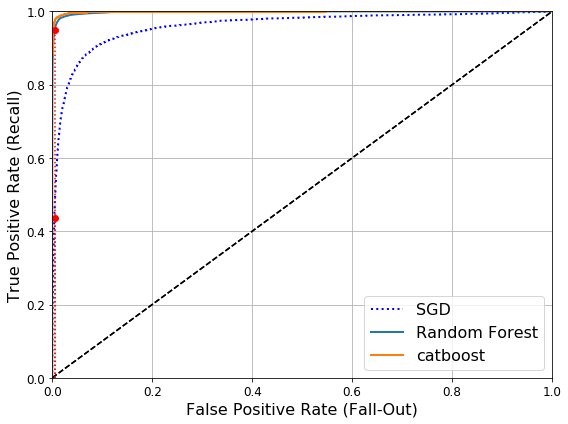

In [74]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plot_roc_curve(fpr_cb, tpr_cb, "catboost")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [75]:
roc_auc_score(y_train_5, y_scores_cb)

# sgd: 0.9604938554008616
# random forest: 0.9983436731328145
# 위 점수보다 조금 나은 점수이다.

0.9988110024012044

# Multiclass classification

SVC(Support Vector Classifier)는 '다범주 분류 문제'를 내부적으로 OvO(one-versus-one)로 바꿔서 풀어낸다. 즉 N개의 클래스가 있는 문제라면 2개 클래스에 대한 ${N\choose 2}$개의 모델을 만들고, 가장 높은 점수를 얻은 클래스로 예측한다. OvO의 각 2진 분류 모델은 전체 데이터가 아닌 일부 데이터만으로 학습하므로, SVM처럼 데이터량이 많아지면 문제가 생기는 모델을 사용할때 이 방식(OvO)이 좋은 경우도 있다.

In [76]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

아래 decision_function은 10개 범주에 대한 점수를 나타내며, 예측할때는 이들 중 점수가 가장 높은 범주가 선택된다.

In [77]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [78]:
np.argmax(some_digit_scores)

5

classes_ 값은 값으로 정렬된 범주들의 인덱스를 의미한다.(값이 아니다.)

In [79]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [80]:
svm_clf.classes_[5]

5

###### OneVsRestClassifier이건 뭘까? 

앞서 SVC는 OvO 방식으로 모델을 학습시켰다.    
OneVsRestClassifier를 이용하면 SVC가 OvR(one-versus-rest) 방식으로 동작하도록 강제할수도 있다.

In [81]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [82]:
len(ovr_clf.estimators_)

10

In [83]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [84]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [85]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87082583, 0.87089354, 0.88628294])

###### 단순히 스케일링만 해 줬는데 성능이 좋아진다.

In [86]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89957009, 0.89344467, 0.89963495])

# 3.5 Error Analysis 

In [87]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5576,    0,   21,    6,    9,   43,   37,    6,  224,    1],
       [   0, 6398,   38,   23,    4,   44,    4,    8,  213,   10],
       [  26,   27, 5242,   90,   71,   26,   62,   36,  371,    7],
       [  24,   17,  117, 5220,    2,  208,   28,   40,  405,   70],
       [  12,   14,   48,   10, 5192,   10,   36,   26,  330,  164],
       [  28,   15,   33,  166,   55, 4437,   76,   14,  538,   59],
       [  30,   14,   41,    2,   43,   95, 5560,    4,  128,    1],
       [  21,    9,   52,   27,   51,   12,    3, 5693,  188,  209],
       [  17,   63,   46,   90,    3,  125,   25,   10, 5429,   43],
       [  23,   18,   31,   66,  116,   32,    1,  179,  377, 5106]],
      dtype=int64)

In [88]:
# since sklearn 0.22, you can use sklearn.metrics.plot_confusion_matrix()
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Saving figure confusion_matrix_plot


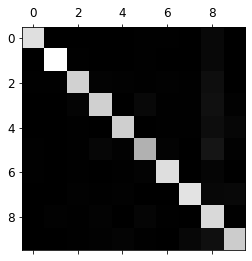

In [89]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [90]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


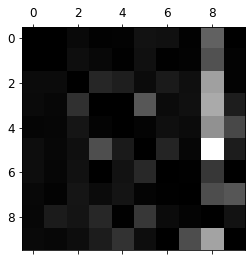

In [91]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

Saving figure error_analysis_digits_plot


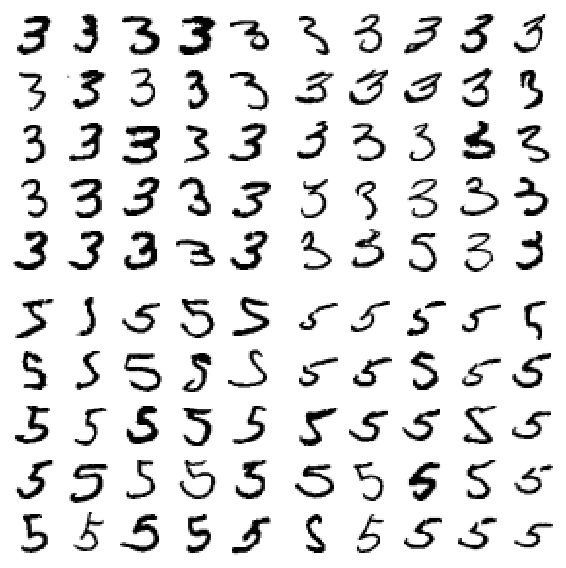

In [92]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

# Multilabel classification

In [94]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [95]:
knn_clf.predict([some_digit])

array([[False,  True]])

**Warning**: the following cell may take a very long time (possibly hours depending on your hardware).

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

# Multioutput classification

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

# Extra material

## Dummy (ie. random) classifier

In [ ]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier()
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

In [ ]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

## KNN classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

In [ ]:
y_knn_pred = knn_clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

In [ ]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [ ]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

In [ ]:
knn_clf.fit(X_train_expanded, y_train_expanded)

In [ ]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_knn_expanded_pred)

In [ ]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

In [ ]:
plot_digit(ambiguous_digit)

# Exercise solutions

## 1. An MNIST Classifier With Over 97% Accuracy

**Warning**: the next cell may take hours to run, depending on your hardware.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

## 2. Data Augmentation

In [ ]:
from scipy.ndimage.interpolation import shift

In [ ]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

In [ ]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [ ]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [ ]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [ ]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [ ]:
knn_clf.fit(X_train_augmented, y_train_augmented)

In [ ]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

By simply augmenting the data, we got a 0.5% accuracy boost. :)

## 3. Tackle the Titanic dataset

The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.

First, login to [Kaggle](https://www.kaggle.com/) and go to the [Titanic challenge](https://www.kaggle.com/c/titanic) to download `train.csv` and `test.csv`. Save them to the `datasets/titanic` directory.

Next, let's load the data:

In [ ]:
import os

TITANIC_PATH = os.path.join("datasets", "titanic")

In [ ]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [ ]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

The data is already split into a training set and a test set. However, the test data does *not* contain the labels: your goal is to train the best model you can using the training data, then make your predictions on the test data and upload them to Kaggle to see your final score.

Let's take a peek at the top few rows of the training set:

In [ ]:
train_data.head()

The attributes have the following meaning:
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

Let's get more info to see how much data is missing:

In [ ]:
train_data.info()

Okay, the **Age**, **Cabin** and **Embarked** attributes are sometimes null (less than 891 non-null), especially the **Cabin** (77% are null). We will ignore the **Cabin** for now and focus on the rest. The **Age** attribute has about 19% null values, so we will need to decide what to do with them. Replacing null values with the median age seems reasonable.

The **Name** and **Ticket** attributes may have some value, but they will be a bit tricky to convert into useful numbers that a model can consume. So for now, we will ignore them.

Let's take a look at the numerical attributes:

In [ ]:
train_data.describe()

* Yikes, only 38% **Survived**. :(  That's close enough to 40%, so accuracy will be a reasonable metric to evaluate our model.
* The mean **Fare** was £32.20, which does not seem so expensive (but it was probably a lot of money back then).
* The mean **Age** was less than 30 years old.

Let's check that the target is indeed 0 or 1:

In [ ]:
train_data["Survived"].value_counts()

Now let's take a quick look at all the categorical attributes:

In [ ]:
train_data["Pclass"].value_counts()

In [ ]:
train_data["Sex"].value_counts()

In [ ]:
train_data["Embarked"].value_counts()

The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

**Note**: the code below uses a mix of `Pipeline`, `FeatureUnion` and a custom `DataFrameSelector` to preprocess some columns differently.  Since Scikit-Learn 0.20, it is preferable to use a `ColumnTransformer`, like in the previous chapter.

Now let's build our preprocessing pipelines. We will reuse the `DataframeSelector` we built in the previous chapter to select specific attributes from the `DataFrame`:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

Let's build the pipeline for the numerical attributes:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [ ]:
num_pipeline.fit_transform(train_data)

We will also need an imputer for the string categorical columns (the regular `SimpleImputer` does not work on those):

In [ ]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

Now we can build the pipeline for the categorical attributes:

In [ ]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [ ]:
cat_pipeline.fit_transform(train_data)

Finally, let's join the numerical and categorical pipelines:

In [ ]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

Cool! Now we have a nice preprocessing pipeline that takes the raw data and outputs numerical input features that we can feed to any Machine Learning model we want.

In [ ]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

Let's not forget to get the labels:

In [ ]:
y_train = train_data["Survived"]

We are now ready to train a classifier. Let's start with an `SVC`:

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

Great, our model is trained, let's use it to make predictions on the test set:

In [ ]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

And now we could just build a CSV file with these predictions (respecting the format excepted by Kaggle), then upload it and hope for the best. But wait! We can do better than hope. Why don't we use cross-validation to have an idea of how good our model is?

In [ ]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

Okay, over 73% accuracy, clearly better than random chance, but it's not a great score. Looking at the [leaderboard](https://www.kaggle.com/c/titanic/leaderboard) for the Titanic competition on Kaggle, you can see that you need to reach above 80% accuracy to be within the top 10% Kagglers. Some reached 100%, but since you can easily find the [list of victims](https://www.encyclopedia-titanica.org/titanic-victims/) of the Titanic, it seems likely that there was little Machine Learning involved in their performance! ;-) So let's try to build a model that reaches 80% accuracy.

Let's try a `RandomForestClassifier`:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

That's much better!

Instead of just looking at the mean accuracy across the 10 cross-validation folds, let's plot all 10 scores for each model, along with a box plot highlighting the lower and upper quartiles, and "whiskers" showing the extent of the scores (thanks to Nevin Yilmaz for suggesting this visualization). Note that the `boxplot()` function detects outliers (called "fliers") and does not include them within the whiskers. Specifically, if the lower quartile is $Q_1$ and the upper quartile is $Q_3$, then the interquartile range $IQR = Q_3 - Q_1$ (this is the box's height), and any score lower than $Q_1 - 1.5 \times IQR$ is a flier, and so is any score greater than $Q3 + 1.5 \times IQR$.

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

To improve this result further, you could:
* Compare many more models and tune hyperparameters using cross validation and grid search,
* Do more feature engineering, for example:
  * replace **SibSp** and **Parch** with their sum,
  * try to identify parts of names that correlate well with the **Survived** attribute (e.g. if the name contains "Countess", then survival seems more likely),
* try to convert numerical attributes to categorical attributes: for example, different age groups had very different survival rates (see below), so it may help to create an age bucket category and use it instead of the age. Similarly, it may be useful to have a special category for people traveling alone since only 30% of them survived (see below).

In [ ]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

In [ ]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

## 4. Spam classifier

First, let's fetch the data:

In [ ]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", HAM_URL), ("spam.tar.bz2", SPAM_URL)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=SPAM_PATH)
        tar_bz2_file.close()

In [ ]:
fetch_spam_data()

Next, let's load all the emails:

In [ ]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [ ]:
len(ham_filenames)

In [ ]:
len(spam_filenames)

We can use Python's `email` module to parse these emails (this handles headers, encoding, and so on):

In [ ]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [ ]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

Let's look at one example of ham and one example of spam, to get a feel of what the data looks like:

In [ ]:
print(ham_emails[1].get_content().strip())

In [ ]:
print(spam_emails[6].get_content().strip())

Some emails are actually multipart, with images and attachments (which can have their own attachments). Let's look at the various types of structures we have:

In [ ]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [ ]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [ ]:
structures_counter(ham_emails).most_common()

In [ ]:
structures_counter(spam_emails).most_common()

It seems that the ham emails are more often plain text, while spam has quite a lot of HTML. Moreover, quite a few ham emails are signed using PGP, while no spam is. In short, it seems that the email structure is useful information to have.

Now let's take a look at the email headers:

In [ ]:
for header, value in spam_emails[0].items():
    print(header,":",value)

There's probably a lot of useful information in there, such as the sender's email address (12a1mailbot1@web.de looks fishy), but we will just focus on the `Subject` header:

In [ ]:
spam_emails[0]["Subject"]

Okay, before we learn too much about the data, let's not forget to split it into a training set and a test set:

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Okay, let's start writing the preprocessing functions. First, we will need a function to convert HTML to plain text. Arguably the best way to do this would be to use the great [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) library, but I would like to avoid adding another dependency to this project, so let's hack a quick & dirty solution using regular expressions (at the risk of [un̨ho͞ly radiańcé destro҉ying all enli̍̈́̂̈́ghtenment](https://stackoverflow.com/a/1732454/38626)). The following function first drops the `<head>` section, then converts all `<a>` tags to the word HYPERLINK, then it gets rid of all HTML tags, leaving only the plain text. For readability, it also replaces multiple newlines with single newlines, and finally it unescapes html entities (such as `&gt;` or `&nbsp;`):

In [ ]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

Let's see if it works. This is HTML spam:

In [ ]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

And this is the resulting plain text:

In [ ]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")

Great! Now let's write a function that takes an email as input and returns its content as plain text, whatever its format is:

In [ ]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [ ]:
print(email_to_text(sample_html_spam)[:100], "...")

Let's throw in some stemming! For this to work, you need to install the Natural Language Toolkit ([NLTK](http://www.nltk.org/)). It's as simple as running the following command (don't forget to activate your virtualenv first; if you don't have one, you will likely need administrator rights, or use the `--user` option):

`$ pip3 install nltk`

In [ ]:
try:
    import nltk

    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Error: stemming requires the NLTK module.")
    stemmer = None

We will also need a way to replace URLs with the word "URL". For this, we could use hard core [regular expressions](https://mathiasbynens.be/demo/url-regex) but we will just use the [urlextract](https://github.com/lipoja/URLExtract) library. You can install it with the following command (don't forget to activate your virtualenv first; if you don't have one, you will likely need administrator rights, or use the `--user` option):

`$ pip3 install urlextract`

In [ ]:
# if running this notebook on Colab, we just pip install urlextract
try:
    import google.colab
    !pip install -q -U urlextract
except ImportError:
    pass # not running on Colab

In [ ]:
try:
    import urlextract # may require an Internet connection to download root domain names
    
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("Error: replacing URLs requires the urlextract module.")
    url_extractor = None

We are ready to put all this together into a transformer that we will use to convert emails to word counters. Note that we split sentences into words using Python's `split()` method, which uses whitespaces for word boundaries. This works for many written languages, but not all. For example, Chinese and Japanese scripts generally don't use spaces between words, and Vietnamese often uses spaces even between syllables. It's okay in this exercise, because the dataset is (mostly) in English.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

Let's try this transformer on a few emails:

In [ ]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

This looks about right!

Now we have the word counts, and we need to convert them to vectors. For this, we will build another transformer whose `fit()` method will build the vocabulary (an ordered list of the most common words) and whose `transform()` method will use the vocabulary to convert word counts to vectors. The output is a sparse matrix.

In [ ]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common_ = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [ ]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

In [ ]:
X_few_vectors.toarray()

What does this matrix mean? Well, the 99 in the second row, first column, means that the second email contains 99 words that are not part of the vocabulary. The 11 next to it means that the first word in the vocabulary is present 11 times in this email. The 9 next to it means that the second word is present 9 times, and so on. You can look at the vocabulary to know which words we are talking about. The first word is "the", the second word is "of", etc.

In [ ]:
vocab_transformer.vocabulary_

We are now ready to train our first spam classifier! Let's transform the whole dataset:

In [ ]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

**Note**: to be future-proof, we set `solver="lbfgs"` since this will be the default value in Scikit-Learn 0.22.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

Over 98.7%, not bad for a first try! :) However, remember that we are using the "easy" dataset. You can try with the harder datasets, the results won't be so amazing. You would have to try multiple models, select the best ones and fine-tune them using cross-validation, and so on.

But you get the picture, so let's stop now, and just print out the precision/recall we get on the test set:

In [ ]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))